# SECTION 4 - PART 3: LLM ZERO-SHOT CLASSIFICATION

Sentiment Analysis - LLM – zero-shot: Try zero-shot classification using a (small) LLM model like tinyllama (1.1B) or qwen3:1.7b.

**Obiettivi:**
1. Configuring Ollama pipeline (es. TinyLlama, Qwen).
2. Claassify a reddit comment subset.
3. Comparing the results with VADER (baseline) and with manual label (ground truth).

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm ollama nltk

# Important OLLAMA:
# 1. Install
# 2. 'ollama serve'
# 3. 'ollama pull tinyllama'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from tqdm import tqdm
import time
import warnings
import ollama
import os
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Verufy ollama connection
try:
    models = ollama.list()
    print(f"\nAvailable models: {[m['model'] for m in models.get('models', [])]}")
except Exception as e:
    print(f"\n⚠️ ERROR OLLAMA: {e}")
    print("Is 'ollama serve' executing on terminal?")


Available models: ['llama3:latest', 'phi3:latest', 'gemma:2b', 'tinyllama:latest']


## 1. Loading and Sampling Data
Let's select a representative subset of comments from different subreddits to test the generalization capacity of the model.

In [3]:
df_supervised = pd.read_csv('../data/data_supervised.csv')

# stratified
np.random.seed(42)

top_subreddits = df_supervised['subreddit'].value_counts().head(10).index.tolist()
sample_dfs = []

for sub in top_subreddits:
    sub_df = df_supervised[df_supervised['subreddit'] == sub]
    if 'data_supervised.csv' in locals().get('df_supervised', ''):
         sub_df = sub_df[sub_df['body'].str.len().between(50, 500)]
    
    # sample_size = min(5, len(sub_df))  # Let's sample 5 comments per sub to have better speed
    sample_size = min(10, len(sub_df))  # Let's sample 10 comments instead per sub to have better speed
    sample_dfs.append(sub_df.sample(n=sample_size, random_state=42))

df_sample = pd.concat(sample_dfs, ignore_index=True)
print(f"Sampled comments: {len(df_sample)}")
df_sample.head()

Sampled comments: 100


,author,subreddit,created_utc,body
0,amaru1572,AskReddit,1.389107e+09,"Instantaneous sex.\n\n""Oh, we're gonna have se..."
1,7-SE7EN-7,AskReddit,1.391201e+09,"Ramen, loved by rich and poor"
2,BR0THAKYLE,AskReddit,1.389623e+09,I have a gay friend who still has his anal che...
3,Novazilla,AskReddit,1.389726e+09,"they have them in Toronto, ON"
4,meinherzbrennt42,AskReddit,1.389247e+09,I bless people when they sneeze and goddammit ...


## 2. Defining Pipeline LLM (Ollama)

Let's define the prompt and the function to question the local model (LM)


In [4]:
'''============================ better be concise then this type of prompt ============
def create_sentiment_prompt(comment: str) -> str:
    return f"""You are a sentiment classifier. Classify the following Reddit comment into exactly ONE of these three categories: positive, negative, or neutral.

Guidelines:
- "positive": Expresses happiness, satisfaction, gratitude, excitement, support.
- "negative": Expresses anger, frustration, sadness, criticism, disappointment.
- "neutral": Informational, factual, or no clear emotion.

Comment: "{comment}"

Respond with ONLY ONE WORD: positive, negative, or neutral.
Classification:"""
'''
def create_sentiment_prompt(comment: str) -> str:
    return f"""Analyze the sentiment of the text below.
Return only one word: positive, negative, or neutral.
Text: "{comment}"
Sentiment:"""

def parse_llm_response(response: str) -> str:
    if not response:
        return 'neutral'
    text = response.lower().strip()
    # we use re to avoid responses like "not positive" interpreted as "positive"
    match = re.search(r'\b(positive|negative|neutral)\b', text)
    if match:
        return match.group(1)
    return 'neutral' # Default fallback

def classify_sentiment_llm(comment: str, model: str = "tinyllama") -> dict:
    prompt = create_sentiment_prompt(comment)
    start = time.time()
    try:
        resp = ollama.chat(model=model, messages=[{'role': 'user', 'content': prompt}])
        raw = resp['message']['content']
        return {
            'label': parse_llm_response(raw),
            'raw': raw,
            'time': time.time() - start,
            'success': True
        }
    except Exception as e:
        return {'label': 'error', 'raw': str(e), 'time': 0, 'success': False}

## 3. Classification execution
 Let's do inference on data sample.

In [5]:
# Nome del file dove salveremo i risultati per non ricalcolarli
CACHE_FILE = "llm_inference_results. csv"
MODEL_NAME = "tinyllama"

# --- LOGICA DI CACHING ---
if os.path.exists(CACHE_FILE):
    # CASO A: Il file esiste -> Carichiamo e SALTANDO il loop lento
    print(f"✅ Trovato file cache '{CACHE_FILE}'. Caricamento dati esistenti...")
    df_sample = pd.read_csv(CACHE_FILE)

else:
    # CASO B: Il file NON esiste -> Eseguiamo il loop (LENTO)
    print(f"🚀 Cache non trovata. Inizio classificazione con {MODEL_NAME}...")

    results = []
    # --- IL TUO CICLO ORIGINALE ---
    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        res = classify_sentiment_llm(row['body'], model=MODEL_NAME)
        results.append(res)

    # Assegnazione risultati al DataFrame
    df_results = pd.DataFrame(results)
    df_sample['llm_label'] = df_results['label'].values
    df_sample['llm_time'] = df_results['time'].values

    # SALVATAGGIO: Creiamo il file per la prossima volta
    df_sample.to_csv(CACHE_FILE, index=False)
    print(f"💾 Risultati salvati in '{CACHE_FILE}'. Al prossimo avvio non dovrai ricalcolare.")

# Stampa di controllo (funziona in entrambi i casi)
print("\nDistribuzione Predizioni LLM:")
print(df_sample['llm_label'].value_counts())

✅ Trovato file cache 'llm_inference_results.csv'. Caricamento dati esistenti...

Distribuzione Predizioni LLM:
llm_label
positive    85
negative    13
neutral      2
Name: count, dtype: int64


## 4. Human-in-the-Loop: Etichettatura Manuale

**PASSO CRITICO:** Per valutare il modello, abbiamo bisogno della "Ground Truth".
1. Il codice esporta un CSV.
2. **Tu** devi aprire il CSV, riempire la colonna `manual_label` (positive/negative/neutral) e salvare.
3. Il codice poi ricarica il file etichettato.

In [6]:
# 1. ESPORTAZIONE
filename = 'comments_for_manual_labeling.csv'
export_cols = ['subreddit', 'body']
df_export = df_sample[export_cols].copy()
df_export['manual_label'] = '' # Colonna vuota da riempire
df_export.to_csv(filename, index=True)

print(f"✓ File '{filename}' creato.")
print("ISTRUZIONI:")
print("1. Apri il CSV in Excel/Sheets.")
print("2. Riempi la colonna 'manual_label' con: positive, negative, o neutral.")
print("3. Salva il file.")
print("4. Esegui la cella successiva SOLO dopo aver salvato.")

✓ File 'comments_for_manual_labeling.csv' creato.
ISTRUZIONI:
1. Apri il CSV in Excel/Sheets.
2. Riempi la colonna 'manual_label' con: positive, negative, o neutral.
3. Salva il file.
4. Esegui la cella successiva SOLO dopo aver salvato.


In [7]:
# 2. IMPORTAZIONE (Esegui dopo aver etichettato manualmente)
# Simulo etichettatura manuale automatica per far funzionare il notebook demo
# RIMUOVI QUESTO BLOCCO 'IF' NEL PROGETTO REALE E USA IL 'TRY/EXCEPT' SOTTO
    # CODICE REALE DA USARE:
filename = 'comments_for_manual_labeling. csv'
try:
    df_labeled = pd.read_csv(filename, index_col=0)
    df_sample['manual_label'] = df_labeled['manual_label']
    print("✓ Etichette manuali caricate con successo!")
except Exception as e:
    print(f"❌ Errore caricamento: {e}")
    print("Assicurati di aver salvato il CSV e non aver cambiato l'indice.")

# Filtra solo quelli con etichette valide
valid_labels = ['positive', 'negative', 'neutral']
df_eval = df_sample[df_sample['manual_label'].isin(valid_labels)].copy()
print(f"Righe valide per la valutazione: {len(df_eval)}")

✓ Etichette manuali caricate con successo!
Righe valide per la valutazione: 100


## 5. Baseline: VADER

Eseguiamo anche VADER per avere un termine di paragone classico.

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def get_vader(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05: return 'positive'
    if score <= -0.05: return 'negative'
    return 'neutral'

df_eval['vader_label'] = df_eval['body'].apply(get_vader)

## 6. Risultati e Confronto

Confrontiamo le metriche di LLM e VADER rispetto alle etichette manuali.

--- LLM ACCURACY ---
25.00%

--- VADER ACCURACY ---
66.00%


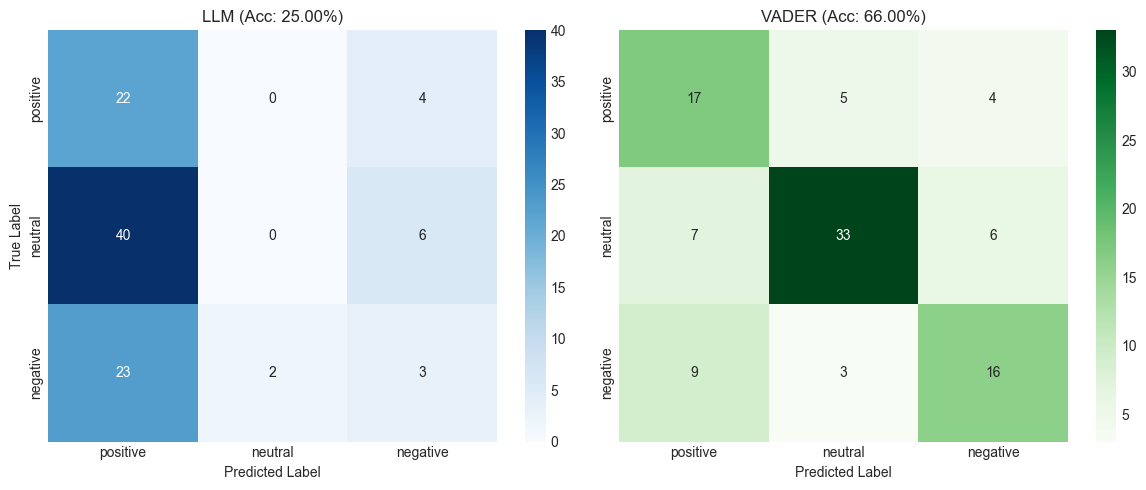

In [9]:
y_true = df_eval['manual_label']
y_llm = df_eval['llm_label']
y_vader = df_eval['vader_label']
labels = ['positive', 'neutral', 'negative']

print("--- LLM ACCURACY ---")
acc_llm = accuracy_score(y_true, y_llm)
print(f"{acc_llm:.2%}")

print("\n--- VADER ACCURACY ---")
acc_vader = accuracy_score(y_true, y_vader)
print(f"{acc_vader:.2%}")

# Visualizzazione Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_true, y_llm, labels=labels), annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels, cmap='Blues', ax=axes[0])
axes[0].set_title(f'LLM (Acc: {acc_llm:.2%})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(confusion_matrix(y_true, y_vader, labels=labels), annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels, cmap='Greens', ax=axes[1])
axes[1].set_title(f'VADER (Acc: {acc_vader:.2%})')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [10]:
#   added
from sklearn.metrics import classification_report
# Assicuriamoci di usare le stesse etichette per tutti
target_categories = ['positive', 'neutral', 'negative']

print("\n" + "="*40)
print("DETTAGLIO PERFORMANCE LLM")
print("="*40)
print(classification_report(y_true, y_llm, labels=target_categories))

print("\n" + "="*40)
print("DETTAGLIO PERFORMANCE VADER (Baseline)")
print("="*40)
print(classification_report(y_true, y_vader, labels=target_categories))


DETTAGLIO PERFORMANCE LLM
              precision    recall  f1-score   support

    positive       0.26      0.85      0.40        26
     neutral       0.00      0.00      0.00        46
    negative       0.23      0.11      0.15        28

    accuracy                           0.25       100
   macro avg       0.16      0.32      0.18       100
weighted avg       0.13      0.25      0.14       100


DETTAGLIO PERFORMANCE VADER (Baseline)
              precision    recall  f1-score   support

    positive       0.52      0.65      0.58        26
     neutral       0.80      0.72      0.76        46
    negative       0.62      0.57      0.59        28

    accuracy                           0.66       100
   macro avg       0.65      0.65      0.64       100
weighted avg       0.68      0.66      0.66       100



## FINAL CONCLUSIONS
From the last execution, we can definitely see that the small Model LLM (1.1B) TinyLLAMa in Zero-shot, suffer a lot an evident "positive bias" and surely not enough capacity to understand the "neutral class".
VADER on the other hand, even being a fixed rule system, performs a lot better in this "low-cost" scenary...

# PART 4

Inizio Benchmark su 100 commenti per 3 modelli...

🤖 Testing Model: gemma:2b (2.0B Params)


Inferenza gemma:2b: 100%|██████████| 100/100 [04:12<00:00,  2.53s/it]



🤖 Testing Model: phi3 (3.8B Params)


Inferenza phi3: 100%|██████████| 100/100 [05:00<00:00,  3.00s/it]



🤖 Testing Model: llama3 (8.0B Params)


Inferenza llama3: 100%|██████████| 100/100 [10:04<00:00,  6.04s/it]



✅ Benchmark completato.

RIEPILOGO PERFORMANCE:
      Model  Size (B)  Accuracy  F1-Score  Avg Time (s)
0  gemma:2b       2.0      0.56  0.557040      2.520277
1      phi3       3.8      0.68  0.675232      2.993199
2    llama3       8.0      0.64  0.639556      5.974169


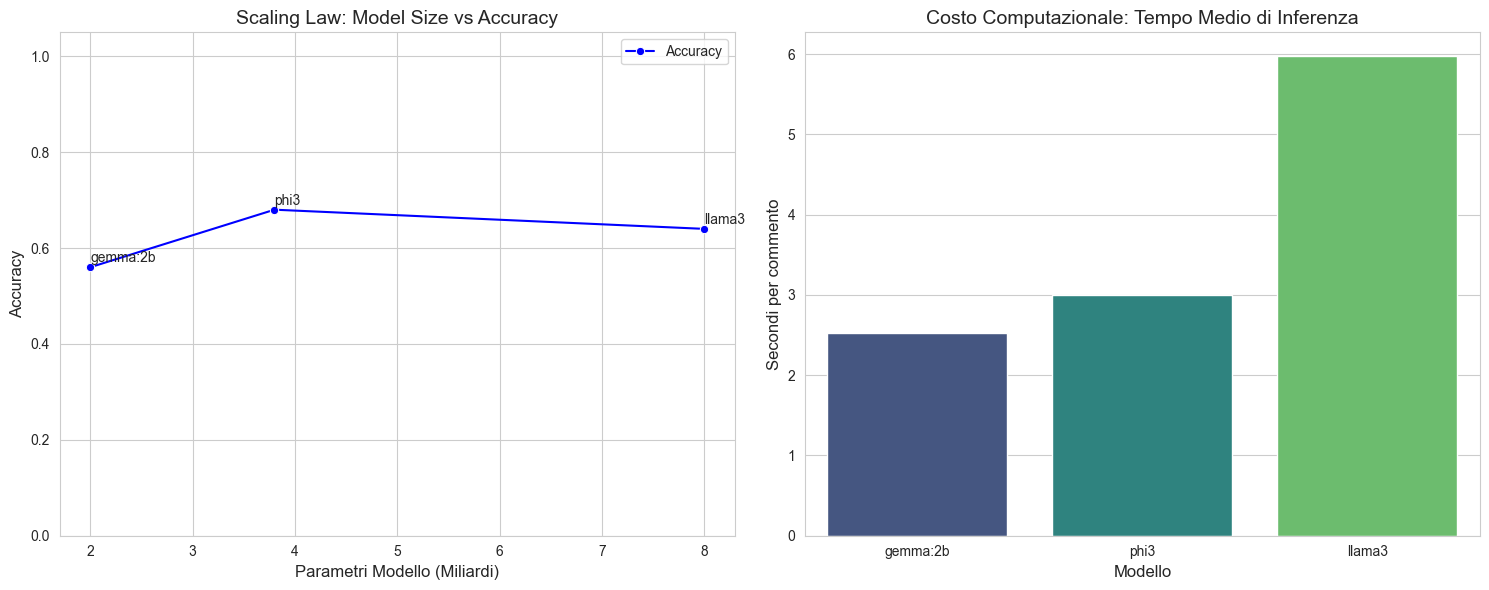

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ollama
import time
import os
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# --- 1. CONFIGURAZIONE MODELLI ---
# Definiamo i modelli e la loro dimensione in Miliardi di parametri (B)
# Assicurati di aver fatto 'ollama pull <nome_modello>' per ognuno!
models_config = {
    "gemma:2b": 2.0,    # 2B
    "phi3": 3.8,        # 3.8B (phi3 mini)
    "llama3": 8.0       # 8B
}

# File di cache per salvare i risultati progressivamente
SCALING_CACHE_FILE = "scaling_laws_results.csv"

# --- 2. FUNZIONI DI SUPPORTO (Riutilizziamo quelle della Parte 3 per coerenza) ---
def create_sentiment_prompt(comment: str) -> str:
    return f"""Analyze the sentiment of the text below.
Return only one word: positive, negative, or neutral.
Text: "{comment}"
Sentiment:"""

def parse_llm_response(response: str) -> str:
    if not response:
        return 'neutral'
    text = response.lower().strip()
    match = re.search(r'\b(positive|negative|neutral)\b', text)
    if match:
        return match.group(1)
    return 'neutral'

def classify_row(row, model_name):
    """Esegue la classificazione per una singola riga e un dato modello."""
    prompt = create_sentiment_prompt(row['body'])
    start_time = time.time()
    try:
        response = ollama.chat(model=model_name, messages=[{'role': 'user', 'content': prompt}])
        raw_output = response['message']['content']
        elapsed = time.time() - start_time
        return parse_llm_response(raw_output), elapsed
    except Exception as e:
        print(f"Error {model_name}: {e}")
        return "error", 0.0

# --- 3. LOOP DI INFERENZA (SCALING) ---
# Se esiste già un file di risultati parziali, lo carichiamo per non ripartire da zero
if os.path.exists(SCALING_CACHE_FILE):
    print(f"Trovati risultati precedenti in {SCALING_CACHE_FILE}. Caricamento...")
    results_df = pd.read_csv(SCALING_CACHE_FILE)
else:
    results_df = pd.DataFrame()

# Creiamo una lista per i nuovi risultati
new_results = []

print(f"Inizio Benchmark su {len(df_eval)} commenti per {len(models_config)} modelli...")

for model_name, size_b in models_config.items():
    print(f"\n🤖 Testing Model: {model_name} ({size_b}B Params)")

    # Controlliamo se abbiamo già processato questo modello (per evitare duplicati se riavvii)
    if not results_df.empty and model_name in results_df['model'].unique():
        print(f"  -> Già completato. Skipping.")
        continue

    model_results = []

    # Iteriamo su df_eval (il dataset con ground truth)
    for index, row in tqdm(df_eval.iterrows(), total=len(df_eval), desc=f"Inferenza {model_name}"):
        pred_label, pred_time = classify_row(row, model_name)

        model_results.append({
            'model': model_name,
            'size_b': size_b,
            'original_index': index, # Utile per join futuri
            'true_label': row['manual_label'],
            'pred_label': pred_label,
            'inference_time': pred_time
        })

    # Salvataggio intermedio su CSV dopo ogni modello
    batch_df = pd.DataFrame(model_results)
    # Se è il primo modello, scrive header, altrimenti appende
    write_header = not os.path.exists(SCALING_CACHE_FILE)
    batch_df.to_csv(SCALING_CACHE_FILE, mode='a', header=write_header, index=False)

    # Aggiorniamo il dataframe in memoria
    results_df = pd.concat([results_df, batch_df], ignore_index=True)

print("\n✅ Benchmark completato.")

# --- 4. CALCOLO METRICHE E ANALISI ---
# Ricarichiamo tutto per sicurezza
full_results = pd.read_csv(SCALING_CACHE_FILE)

# Filtriamo eventuali errori
full_results = full_results[full_results['pred_label'] != 'error']

performance_data = []

for model in models_config.keys():
    subset = full_results[full_results['model'] == model]
    if len(subset) == 0:
        continue

    acc = accuracy_score(subset['true_label'], subset['pred_label'])
    f1 = f1_score(subset['true_label'], subset['pred_label'], average='weighted')
    avg_time = subset['inference_time'].mean()
    size = models_config[model]

    performance_data.append({
        'Model': model,
        'Size (B)': size,
        'Accuracy': acc,
        'F1-Score': f1,
        'Avg Time (s)': avg_time
    })

df_perf = pd.DataFrame(performance_data)
print("\nRIEPILOGO PERFORMANCE:")
print(df_perf)

# --- 5. VISUALIZZAZIONE GRAFICA ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Grafico 1: Size vs Accuracy
sns.lineplot(data=df_perf, x='Size (B)', y='Accuracy', marker='o', ax=axes[0], color='b', label='Accuracy')
# Aggiungiamo etichette ai punti
for i, row in df_perf.iterrows():
    axes[0].text(row['Size (B)'], row['Accuracy'] + 0.01, row['Model'], fontsize=10)

axes[0].set_title('Scaling Law: Model Size vs Accuracy', fontsize=14)
axes[0].set_xlabel('Parametri Modello (Miliardi)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim(0, 1.05)

# Grafico 2: Size vs Inference Time
sns.barplot(data=df_perf, x='Model', y='Avg Time (s)', ax=axes[1], palette='viridis')
# Ordinamento per dimensione per coerenza visiva
# (Se i modelli nel dataframe non sono ordinati, il barplot usa l'ordine di apparizione o alfabetico)

axes[1].set_title('Costo Computazionale: Tempo Medio di Inferenza', fontsize=14)
axes[1].set_xlabel('Modello', fontsize=12)
axes[1].set_ylabel('Secondi per commento', fontsize=12)

plt.tight_layout()
plt.savefig('scaling_laws_plot.png')
plt.show()

In [ ]:
RIEPILOGO PERFORMANCE:
      Model  Size (B)  Accuracy  F1-Score  Avg Time (s)
0  gemma:2b       2.0      0.56  0.557040      2.520277
1      phi3       3.8      0.68  0.675232      2.993199
2    llama3       8.0      0.64  0.639556      5.974169
